In the 'markdown cell' below  replace the `???` with the names of those in your group.

???

# Task 2: classification of cell morphology
_by David Holmberg (2023)_
#### Inspiration
This step by step exercise was inspired by Andrew Ng's **Deep learning** Coursera specialization (https://www.coursera.org/specializations/deep-learning) . This assignment will take you through a machine learning workflow which includes reading datasets, creating and compiling models, training models on datasets, and predicting on the validation sets (for model comparisons). Much of the experience you accumualted during the labs from yesterday and the day before will come in useful here.

#### Datasets
The specific dataset we will use is a subset of the bbbc021v1 MoA dataset (http://mct.aacrjournals.org/content/9/6/1913) available from the Broad Bioimage Benchmark Collection (https://www.nature.com/articles/nmeth.2083). We chose to only use a subset of this data (based on only the six main MoAs) in order that the models we will fit below would not take too long to train.

#### Importance
After you've completed this assignment you will know how to develop and utilize advanced machine learning models (in this case convlutional neural networks (CNNs) applied to high content cell images). Traditional approaches for classyfing such biological cell-images involve complex workflows, with many steps requiring manual implementation. The more modern neural network approach (made possible through the better hardware available today, most notably via GPUs) can perform equally well and often better than the traditional approaches. What's more these CNNs, based merely on the pixel-intensities of the images, require significantly less domain expertise.


#### Note 2
For the assignment we will split the data into a training and validation set and will only optimize our performance on the validation set. Although from the work with the oral cancer data you saw that it is genrally best to keep out a test set on which to make a final evaluation of your chosen model.

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import torch as tch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset


# Helper libraries
from torchsummary import summary
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image
# device = tch.device("cuda" if tch.cuda.is_available() else "cpu")
# from tensorflow.python.util import deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False
# print(tf.__version__)
# tch.backends.cudnn.enabled = False
# tch.cuda.is_available = lambda : False
# device = tch.device('cpu')
!nvidia-smi | grep GeForce
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

|   0  NVIDIA GeForce RTX 3090        Off | 00000000:C2:00.0 Off |                  N/A |


## Functions
Don't worry too much about the code in the functions below, but you might want to go through when they are called later on so that you roughly understand what they're doing.

In [2]:

def load_dataset():
    dirname = 'bbbc021v1_images'
    x_orig = tch.zeros((660, 3, 256, 256), dtype=tch.float32)

    for f in range(x_orig.shape[0]):
        img = Image.open(dirname + '/bbbc021v1_%s.png' % str(f))
        # img = img.convert('RGB')
        img = np.array(img).transpose(2, 0, 1)
        img = tch.tensor(img)
        x_orig[f] = img

    labels = pd.read_csv('bbbc021v1_labels.csv',
                          usecols=["compound", "concentration", "moa"],
                          sep=";")
    y_orig = np.array(labels['moa'])

    return x_orig, y_orig


def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])
    # y = tch.eye(C)[y]
    # y = y.type(tch.int32)
    y = tch.tensor(y, dtype=tch.int64)
    return y



def plot_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = len(train_losses)
    
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    
    ax = fig.add_subplot(131)
    ax.plot(range(1, epochs+1), train_losses, label='Train')
    ax.plot(range(1, epochs+1), val_losses, label='Validation')
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(range(1, epochs+1), np.log(train_losses), label='Train')
    ax.plot(range(1, epochs+1), np.log(val_losses), label='Validation')
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(133)
    ax.plot(range(1, epochs+1), train_accuracies, label='Train')
    ax.plot(range(1, epochs+1), val_accuracies, label='Validation')
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(loc='lower right')
    
    plt.show()
    plt.close()



def plot_confusion_matrix(cm, classes, model_name, cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.close()


def valid_evaluate(model, valid_loader, model_name, num_classes=6):
    model.eval()
    
    y_true = []
    y_pred = []
    
    with tch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = tch.max(outputs, 1)
            # predicted = tch.nn.functional.one_hot(predicted, num_classes)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    # print(f'y pred {y_pred}')
    # print(f'y_tru {y_true}')

    # y_true = [tch.tensor(label).argmax().item() for label in y_true]
    # y_pred = [tch.tensor(pred).argmax().item() for pred in y_pred]
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    
    print('')
    print('Classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3, target_names=class_names))



## Read dataset
Read dataset, prepare with one-hot encoding, and split dataset

In [3]:
X_orig, y_orig = load_dataset()
Y = convert_to_one_hot(y_orig, 6)
X = X_orig/255.
n_train = 500
random.seed(5026)
indices = np.arange(len(Y))
random.shuffle(indices)
X_train, X_valid = X[indices[:n_train]], X[indices[n_train:]]
Y_train, Y_valid = Y[indices[:n_train]], Y[indices[n_train:]]
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid, Y_valid)


## Plot samples of the data

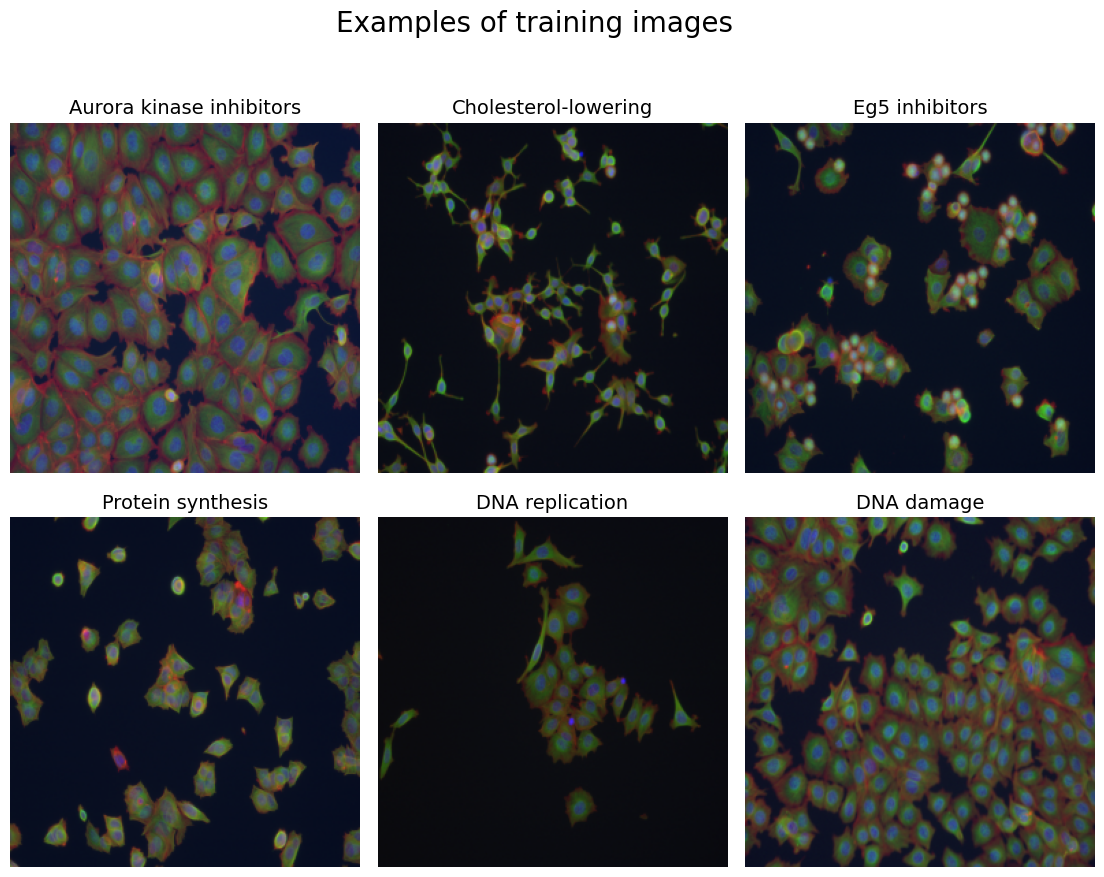

In [4]:
# Run cell to plot few example images of the training set
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle("Examples of training images", fontsize=20)
axes = ax.ravel()
for i in range(len(axes)):
    # idx = np.where(np.argmax(Y_train, axis=1) == i)[0]
    idx = np.where(Y_train == i)[0]
    s_idx = np.random.choice(idx)
    imgt = X_train[s_idx].numpy()
    imgt = imgt.transpose(1, 2, 0)
    img = (imgt*255).astype("uint8")
    axes[i].set_title(y_orig[indices][s_idx], fontsize=14)
    axes[i].imshow(img)
    axes[i].set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

## CNN (LeNet inspired)

You will be implementing LeNet and ResNet in this task. You will implement them using PyTorch

Convolutional Neural Networks (CNNs) use convolutions instead of the normal fully connected layers, which have proven to be highly successful for image recognition tasks. By convolving filters on the input layer and outputting the results to the next layer, the CNN "detects" (or learns) features at different levels of abstraction throughout the network. With lower-level abstractions (like edges and blobs) in the early layers, and higher-level abstractions (like cells) in deeper layers. Figure 1 shows the LeNet inspired CNN that we will shortly turn into TensorFlow code. It has 3 convolutional layers, 3 max pooling layers, and two final fully connected layers.

<p>
    <img src="figs/conv.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 1. LeNet inspired CNN that you will implement.</center>
</p>


If you're getting stuck or stumble upon problems, don't hesitate to use Google or similar to search for answers. There's plenty of information out there regarding PyTorch.

## TASK 1: Coding LeNet
Replace the `???` parts in the cell below with your own code. Start by defining the input shape and then try to code in the variant of LeNet shown above in Figure 1. The final line of your code should be a dense layer with a softmax activation. Once you have your code ready run the cell and see if your model summary matches ours (see below). Note, the stride of 2 for the first convolutional layer is something you should define within the braces of `layers.Conv2D(...)` along with the other arguments you are now used to. You can press `STIFT+TAB` from inside the braces to see the aruments that can be passed. Also pay attention to how the dimensions above change from one part of the model to the next - with the max pooling we don't always use the defualt pool size of `(2, 2)`. To compensate for over-fitting add a dropout layer prior to your prediction layer with a dropout rate of `0.2`. Name your model `LeNet`.

### Define and sumarise the LeNet model

In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,  stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,  stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=4)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool4(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool4(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x
num_classes = 6
LeNet_model = LeNet(num_classes)
input_size = (3, 256, 256)
LeNet_model = LeNet_model.to(device).float()
summary(LeNet_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]           1,216
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]          12,832
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          51,264
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                 [-1, 1024]       1,049,600
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                    [-1, 6]           6,150
          Softmax-14                   

### Did you define LeNet correctly?
At the end of the summary you should see the following:

Total params: 1,121,062

Trainable params: 1,121,062

Non-trainable params: 0


## Compile the LeNet model

In [6]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(LeNet_model.parameters(), lr=0.001)


## Fit and evaluate the LeNet model

In [7]:
num_epochs = 5
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
train_losses = []
val_losses = []
train_accuracies = []  # List to store train accuracies
val_accuracies = []  
for epoch in range(num_epochs):
    LeNet_model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Iterate through batches using DataLoader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # inputs = inputs.to(device)
        outputs = LeNet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = tch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    LeNet_model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with tch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = LeNet_model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = tch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
    
    valid_loss /= len(valid_loader)
    val_losses.append(valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    val_accuracies.append(valid_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")




Epoch [1/5] - Train Loss: 1.7787 - Valid Loss: 1.7387
Epoch [2/5] - Train Loss: 1.6355 - Valid Loss: 1.6961
Epoch [3/5] - Train Loss: 1.6526 - Valid Loss: 1.6136
Epoch [4/5] - Train Loss: 1.5463 - Valid Loss: 1.5344
Epoch [5/5] - Train Loss: 1.5078 - Valid Loss: 1.5883


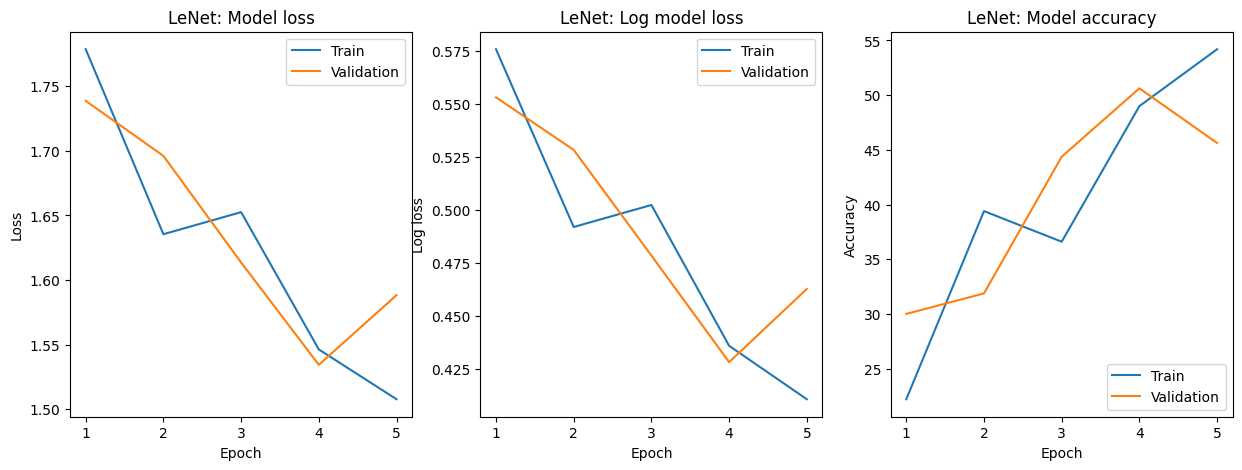

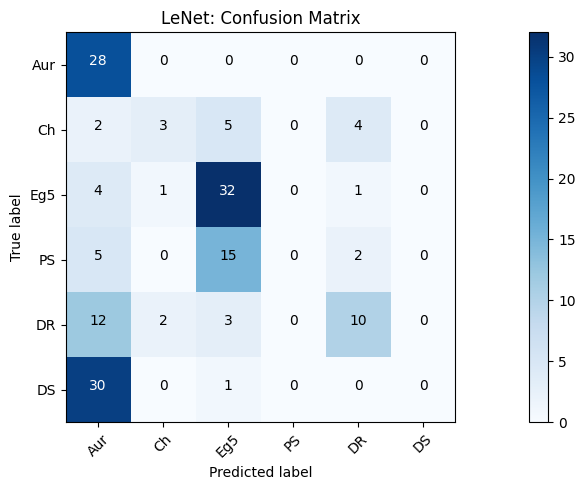


Classification report for validation data:
              precision    recall  f1-score   support

         Aur      0.346     1.000     0.514        28
          Ch      0.500     0.214     0.300        14
         Eg5      0.571     0.842     0.681        38
          PS      0.000     0.000     0.000        22
          DR      0.588     0.370     0.455        27
          DS      0.000     0.000     0.000        31

    accuracy                          0.456       160
   macro avg      0.334     0.404     0.325       160
weighted avg      0.339     0.456     0.355       160



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Plot training history
plot_history(train_losses, val_losses, train_accuracies, val_accuracies, 'LeNet')

# Evaluate on validation data
valid_evaluate(LeNet_model, valid_loader, 'LeNet')


## Multiple runs of the same model


Models will converge at very large epoch values - however, there is a natural stocicisity to neural networks. It is therefore a good idea to run the model multiple times (preferable with new parallel copies) and compare them.

## Notes
Your probably noticed that the training was quite eratic for your ResNet model above (i.e. the training curve was quite jaggedy). We could combat this with changes to the model architecture, the batch size and learning rate. We could also perhaps improve things with data augmentation. We will not explore these modifications here though.

This was a big model that we trained, with almost 5 million parameters. With only 500 images for training this was rather ambitious!